## **CNN with MNIST Data**

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf                       
import numpy as np                           
import matplotlib.pyplot as plt               
%matplotlib inline

In [13]:
print(tf.__version__)

2.7.0


GPU' ya baglanmadik. CPU ile calisacagiz. (CPU' larda 4 cekirdek varken bir GPU' da 1000' den fazla cekirdek olabilir. GPU' lar daha basit islem yaparlar fakat cekirdekleri fazla oldugu icin daha hizlidirlar. CPU az cekirdeklidir ama daha komplex islem yapar)

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-03-10 15:08:37.394082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 15:08:37.564228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 15:08:37.564890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU' nun memory' sini release ettik :

In [3]:
# Release GPU memory to prevent memory-leaks.

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [4]:
!nvidia-smi

Thu Mar 10 15:05:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P5     7W /  N/A |      8MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

MNIST data seti, computer visula' da kullanilan meshur bir data seti. Fashion ile alakali 28x28 boyutlu grayscale kucuk resimler var. Bu data seti ANN ile de modellenebilir. Cok kullanilan bir dataseti oldugu icin Keras' in icinden import edilebiliyor. Train ve test datalarini ayri ayri alabiliyoruz :

In [5]:
from tensorflow.keras.datasets.mnist import load_data    # To load the MNIST digit dataset

(X_train, y_train) , (X_test, y_test) = load_data()      # Loading data

In [ ]:
Train datasinda 60000 resim, test datasinda 10000 resim var :

In [6]:
print("There are ", len(X_train), "images in the training dataset")     
print("There are ", len(X_test), "images in the test dataset")   

There are  60000 images in the training dataset
There are  10000 images in the test dataset


Rastgele bir resim secip sekline baktik. Bu datasetindeki resimler 28x28 oldugu icin resim kaliteleri cok kötü. 28x28 tek channel' li resimler var(Renkli degil):

In [7]:
# Checking the shape of one image
X_train[8].shape

(28, 28)

28x28x3 olsaydi resim renkli demek olurdu (3 farkli renk kanali var demektir.)

28x28' lik bir array elde ettik. Buradaki sayilar renk kodlari. 0 sayisi siyahi temsil ediyor; pixeller 255' e dogru gittikce renk beyazlasiyor :

In [8]:
X_train[8]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
         63, 197,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [9]:
X_train[9].shape

(28, 28)

Yukaridaki 9. ornegi __imshow__ ile gorsellestirdik ve gercekte ne olduguna baktik. Resmin etrafindaki alan siyah (0 degeri), resmin kendisi beyaz :

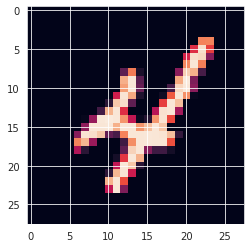

In [10]:
plt.imshow(X_train[9])
# plt.matshow(X_train[5])

Targettaki y degerlerine baktik. Bu degerler aslinda class' lari temsil ediyor ama modele bu haliyle verirsek modelimiz bu reel degerler ile regression modeli yapilacagini düşünür. Bu yüzden encoder uygulayarak degerleri kategorik hale cevirmemiz gerekecek :

In [12]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Datasetinde 0' dan 9' a kadar elle yazilmis rakamlar var ve bu rakamlar digitale aktarilmis. Modelimizi egitip rakam tahminleri yaptiracagiz (Bu dataseti SVM ile de modellenebilir).

Datasetinden random olarak rakamlar sectik ve ekrana yazdirdik. Rakamlarin arka planlari siyah (0), resmin kendisi beyaz (255) :

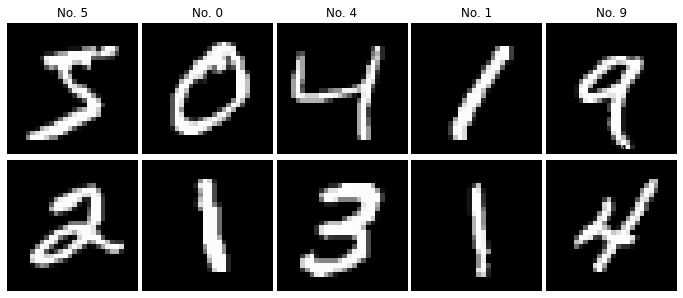

In [ ]:
num_rows, num_cols = 2, 5       # Datadan 2 tane row, 5 tane column sectik.
f, ax = plt.subplots(2, 5, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.02}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
      
        image_index = r * 5 + c
        ax[r,c].axis("off")
        ax[r,c].imshow( X_train[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % y_train[image_index])
plt.show()
plt.close()

## Data Preprocessing

In [ ]:
X_train[9].min()

0

In [ ]:
X_train[9].max()

255

Goruntu islemede tum pixeller 0 ile 255 arasinda deger aldigi icin normalize etmek cok kolay olur. Resimdeki her bir pixel degeri 255' e bölünürse tüm pixel degerleri 0 ile 1 arasinda deger alir. asagidaki islemle train setlerdeki her bir deger 255' e bölünmüs oldu :

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[9].min()

0.0

Normalize isleminden sonra min deger 0, max deger 1 oldu.

In [ ]:
X_train[9].max()

1.0

Normalization islemi yapildiktan sonra resmin yapisi bozulmaz, yine ayni resmi elde edebiliriz :

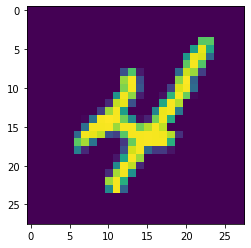

In [ ]:
plt.imshow(X_train[9])

__28, 28, 1 --->__  28x28' lik tek channel (gray scale). Ayni resmi 3 boyutlu olarak ifade ediyoruz. Bu islemi tüm X degerleri icin yaptik (y degerleri icin yapilmaz) :

In [ ]:
X_train = X_train.reshape(X_train.shape[0],28, 28, 1) 
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

y degerlerini categoric hale getirmek icin keras' tan to_categorical' i import ettik. Bu sekilde model artik regression degil, classification yapmasi gerektigini bilecek :

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train ve y_test' i to_categorical icine verdik ve 10 tane class oldugunu yanina belirttik. (Bunu yazmak zorunda degiliz, kendisi anlar fakat yine de belirtmek iyi olur). Ciktida 0 ve 9 dahil 10 tane row oldu :

In [ ]:
Y_train = to_categorical(y_train, 10) 
Y_test = to_categorical(y_test, 10)
Y_test.shape

(10000, 10)

Mesela 0. indexteki resim 5 imis. Bu durumda diger degerlerin hepsi 0 olup 5' e karsilik gelen deger 1 olmus :

In [ ]:
Y_train[0].reshape(-1,1)

Y' de 10 tane column var dolayisiyla classification yaptigimiz icin output layer'da 10 tane nöron olacak. (Kac class var ise o kadar nöron vardir)

Sequential ile layer' lari arka arkaya dizecegiz. Bununla birlikte kullanacagimiz her seyi import ettik :

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

Sequential' i tanimlayarak bir obje olusturduk. Bu objenin icine tek tek layer' lar eklenecek. Icine ilk olarak Convolution layer' i ekledik. Bunun icine de __input_shape__ ekledik. Bu, arka planda input_layer' in gorevini de yapar. Input_shape' i bastan belirledigimiz icin model.summary ile modelin ozetine bakabiliriz. Input boyutu 28x28 idi biz bunu 3 boyutlu hale getirerek 28x28x1 yaptik. 

32 tane filtre(ANN' deki nöron sayisi ile esdeger) belirledik. __kernel_size__ ile her bir filtrenin boyutunu 3x3 olarak belirledik. (Padding ve stride parametrelerini default olarak kullandigimiz icin belirtmedik)

__padding --->__ (Default=valid)

__stride --->__ (Default=1)

__!!__ CNN' de __relu__ kullanilir __!!__

Convolution layer' dan sonra default degerleri ile pooling ekledik.  

Convolution' dan sonra flatten ekledik. __Flatten,__ pool layer' dan aldigi tüm degerleri tek row haline getirdi.

Bu islemden sonra __Dense__ kismini tanimladik. 128 nöronlu, activation' i relu olan bir dense layer kullandik (fully connected asamasi). 

Sonrasinda yine dense ile 10 nöronlu output layer' i tanimladik ve activation' i softmax sectik.

Son olarak loss function' i categorical_crossentropy, optimizer' i adam olarak belirledik ve metrics olarak da accuracy' i takip edecegimizi soylemis olduk. 

Optimizer olarak adam cok sık kullaniliyor cunku en fazla basariyi veren o. Adam' in en buyuk ozelligi; arkada gradient descent algoritmasini uygularken önceki batch' te aldigi türevlerin agirlikli ortalamasini alarak devam etmesidir. Her türev alma isleminden sonra min noktaya yaklastigini dusunurse learning_rate' i otomatik olarak düşürür ki min noktayi atlamasin.

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**A sample example showing the conversion of 3D data to 2D**
![3Dto2D](https://dphi-courses.s3.ap-south-1.amazonaws.com/Deep+Learning+Bootcamp/3D+to++2D.png)

input_shape' i belirledigimiz icin model.summary' e bakabiliyoruz. Ilk katmanda egitilmesi gereken 320 parametre var. Pooling degeri 0, cunku pooling' de egitim islemi yok. Pooling sadece boyut düşürür. Dense layer' da ise egitilmesi gereken 692 bin civari parametre var. Output layer' da ise egitilmesi gereken 1290 parametre var. Toplamda  egitilmesi gereken yaklasik 694 bin parametre var. Bu parametreler 28x28 gibi kucuk image' li bir data seti icin ve sadece bir convolution ve 1 hiddden layer kullandik. Daha kapsamli data setlerinde daha fazla layer kullanildiginda bu parametre sayilari oldukca artar :

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

Modelimizin overfit olmamasi icin EarlyStop' u da ekledik. Early_stop' ta durdurmak icin val_loss' u takip etmesini istedik. 2 epoch boyunca ard arda val_loss degerleri kötulesirse egitimi durduracak.  :

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

early_stop kullanilacaksa epoch sayisinin cok bir onemi kalmiyor. early_stop kullanilmiyor ise modelin cok iyi regularize edilmesi gerekir.

Batch_size genelde 8-64 arasinda verilir. batch_size' i bu modellerde yüksek tutmak memory hatasi verebilir. validation loss' u hesaplamasi icin asagida validation_data icine X_test ve y_test' i verdik. val_loss' u hesaplamak icin bu degerleri kullanacak :

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test,Y_test),callbacks=[early_stop])


Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1570 - accuracy: 0.9534 - val_loss: 0.0745 - val_accuracy: 0.9761
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0510 - accuracy: 0.9844 - val_loss: 0.0513 - val_accuracy: 0.9840
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.0473 - val_accuracy: 0.9837
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0459 - val_accuracy: 0.9857
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0475 - val_accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0459 - val_accuracy: 0.9865


In [ ]:
model.metrics_names  # Modelde kullanilan metrikler

['loss', 'accuracy']

In [ ]:
model.history.history   # Modelin egitimdeki loss ve accuracy history' si 

{'loss': [0.15704083442687988,
  0.05101916566491127,
  0.03318318724632263,
  0.022413989529013634,
  0.014858492650091648,
  0.009890713728964329],
 'accuracy': [0.9533500075340271,
  0.984416663646698,
  0.9894833564758301,
  0.9929333329200745,
  0.9950666427612305,
  0.9967666864395142],
 'val_loss': [0.07450182735919952,
  0.051314085721969604,
  0.047280680388212204,
  0.04590054601430893,
  0.047487203031778336,
  0.04590177908539772],
 'val_accuracy': [0.9761000275611877,
  0.984000027179718,
  0.9836999773979187,
  0.9857000112533569,
  0.9843000173568726,
  0.9865000247955322]}

Yukaridaki egitim history' sini DataFrame' e cevirdik ve asagida da bunun grafigini cizdirdik :

In [ ]:
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.157041,0.953350,0.074502,0.9761
1,0.051019,0.984417,0.051314,0.9840
2,0.033183,0.989483,0.047281,0.9837
3,0.022414,0.992933,0.045901,0.9857
4,0.014858,0.995067,0.047487,0.9843


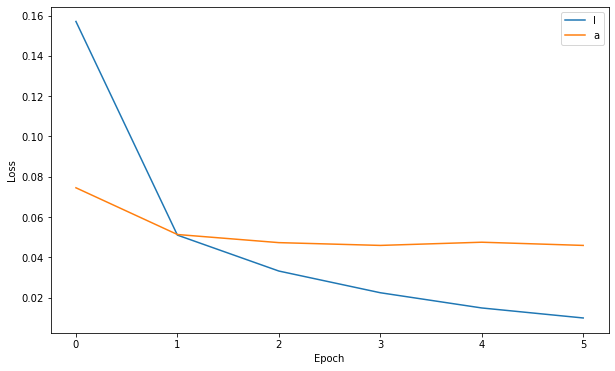

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss)              # DataFrame' den cekilen loss degerleri
plt.plot(summary.val_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend('labels');

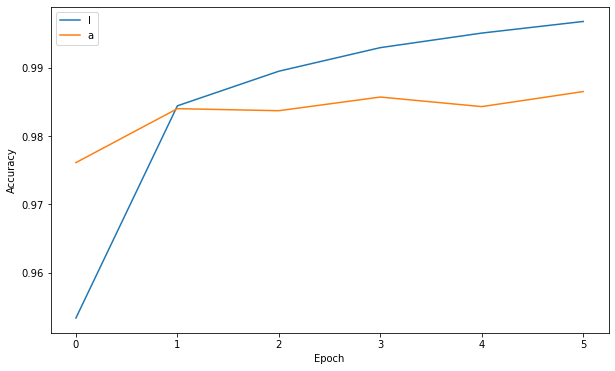

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy)        # DataFrame' den cekilen accuracy degerleri
plt.plot(summary.val_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend('labels');

Modelimizi test setleri üzerinde evaluate ettik; loss ve acccuracy degerlerini aldik :

In [ ]:
print(model.evaluate(X_test,Y_test,verbose=1))

313/313 [==============================] - 1s 5ms/step - loss: 0.0459 - accuracy: 0.9865
[0.04590177908539772, 0.9865000247955322]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

Egittigimiz model ile prediction aldik (Alinan degerler olasilik degerleri) :

In [ ]:
preds = model.predict(X_test)
preds

array([[2.2640905e-11, 5.7559426e-11, 2.8443202e-08, ..., 1.0000000e+00,
        5.1851705e-09, 1.6249132e-08],
       [4.1235687e-08, 9.7200648e-08, 9.9999976e-01, ..., 1.3998480e-13,
        1.4916328e-08, 2.1216791e-09],
       [2.7973197e-08, 9.9999833e-01, 1.6493285e-08, ..., 8.7263817e-07,
        5.2122175e-07, 2.6775734e-08],
       ...,
       [1.3322630e-18, 5.5757439e-15, 7.0235697e-16, ..., 7.7068218e-09,
        4.9686526e-09, 4.0459169e-09],
       [6.1629667e-13, 5.2129398e-18, 2.9092625e-18, ..., 1.3597165e-13,
        4.9119490e-07, 5.7641595e-14],
       [1.7886299e-10, 1.9544814e-13, 1.7428378e-12, ..., 5.9252381e-14,
        2.7562105e-11, 2.3692129e-12]], dtype=float32)

Test datasindaki ilk resmi aldik. Ciktilar sirasiyla resmin 0 classina ait olma olasiligi, 1 classina ait olma olasiligi.. seklinde gidiyor. Her nöron bu resmin hangi class' a ait olduguna dair fikrini olasilik ile belirtiyor. Bir asagidaki kodda argmax ile bu resmin hangi class' a ait olma olasiliginin en yuksek oldugunu alacagiz ki her resim icin sadece bir deger kalsin :

In [ ]:
preds[0]

array([2.2640905e-11, 5.7559426e-11, 2.8443202e-08, 6.7957093e-09,
       7.0849520e-12, 7.2534752e-13, 1.8620123e-16, 1.0000000e+00,
       5.1851705e-09, 1.6249132e-08], dtype=float32)

argmax ile row' daki en yüksek tahmin degerini cektik :

In [ ]:
predictions= np.argmax(preds, axis=1)

In [ ]:
len(predictions)

10000

Elimizde her bir sample icin bir deger olacak sekilde 10000 tane deger olmus oldu. Bu prediction degerlerini yazdirdik ve degerlerin hangi class'a  atandigini listelemis olduk. Ciktiya gore ilk resim 7, ikinci resim 2, 3. resim 1' dir.. diyebiliriz :

In [ ]:
predictions

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

Artik elimizde argmax ile aldigimiz class' lar oldugu icin classification_report' u kullanabiliriz. Model skorlari oldukca yüksek cikti :

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
print(confusion_matrix(y_test, predictions))

[[ 974    1    1    1    0    1    2    0    0    0]
 [   0 1131    1    1    0    0    2    0    0    0]
 [   2    1 1017    0    1    0    3    3    3    2]
 [   0    0    2  994    0    8    0    1    4    1]
 [   0    0    2    0  964    0    4    0    1   11]
 [   1    0    0    4    0  886    1    0    0    0]
 [   7    2    0    0    1    6  940    0    2    0]
 [   1    3    9    0    0    0    0 1010    1    4]
 [   1    0    2    1    0    1    1    3  960    5]
 [   0    3    0    0    4    3    0    7    3  989]]


In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04590177908539772
Test accuracy: 0.9865000247955322


Datasetinin icinden bir resim sectik, bunu DataFrame' e cevirdik ve bu datanin prediction' ini aldik. Prediction islemi sonunda model, bu sayinin 1 oldugunu tahmin etti.

Bizim datadan cektigimiz sample series halinde fakat predict icin DataFrame' e ihtiyacimiz var. Bu yüzden tahmin islemi icin sample' i tek satirli bir DataFrame' e cevirerek tahmin yaptirdik.

In [ ]:
my_number = X_test[5]

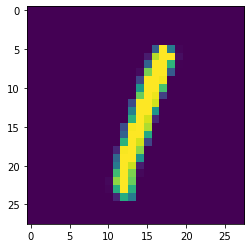

In [ ]:
plt.imshow(my_number.reshape(28,28));     # 5. indexteki resmi görüntüle

__reshape(1,28,28,1) --->__ Modelimizi 4 boyutlu olarak egittigimiz icin prediction' da kullanacagimiz degeri de 4 boyuta cevirdik. Modele, 28x28x1 boyutunda 1 resim var bilgisini vermis olduk :

In [ ]:
model.predict(my_number.reshape(1,28,28,1))

array([[1.3061336e-08, 9.9999511e-01, 8.6170928e-09, 5.6465848e-12,
        7.0288451e-08, 3.5584016e-10, 3.1140465e-10, 4.5637876e-06,
        2.0866831e-07, 6.7501911e-09]], dtype=float32)

Predict' te her class' a ait olma olasiliginin en yüksek degerini argmax ile cektik ve model bu resmin 1 class' ina ait oldugu tahminini yapti :

In [ ]:
# SHAPE --> (num_images,width,height,color_channels)
np.argmax(model.predict(my_number.reshape(1,28,28,1)), axis=1)

array([1], dtype=int64)

In [ ]:
model.save("cnn-1.h5")